In [1990]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
                
        transient = ((self._rho*self._cp*self._grid.vol)*(self._T[1:-1] - self._Told[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (self._rho*self._cp*self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [1991]:
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, ha, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            T_inf........ Ambient Temperature
            ha is the convective heat transfer coefficient
            loc ........ boundary location
            k.......thermal conductivity
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._ha = ha
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            return ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1 /(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")

In [1992]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    


Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 7.383535135776128; Avg. Resid. = 6.51317112967952
Iteration = 1; Max. Resid. = 1.0391687510491465e-13; Avg. Resid. = 6.38378239159465e-14
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 6.932445494374406; Avg. Resid. = 6.117028448334125
Iteration = 1; Max. Resid. = 8.08242361927114e-14; Avg. Resid. = 4.474198789239381e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 6.508835194436642; Avg. Resid. = 5.744578576396137
Iteration = 1; Max. Resid. = 9.414691248821327e-14; Avg. Resid. = 3.108624468950438e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 6.111434068438825; Avg. Resid. = 5.394685502167192
Iteration = 1; Max. Resid. = 5.551115123125783e-14; Avg. Resid. = 3.269606807521086e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 5.738603453000508; Avg. Resid. = 5.066055717848897
Iteration = 1; Max. Resid. = 7.904787935331115e-14; Avg. Resid. = 4.6851411639181606e-14
Timestep = 5; Time = 

[10.68644679 10.68644679 10.56306153 10.31771561  9.9532418   9.47384827
  8.8850701   8.19370529  7.40773631  6.97198711]


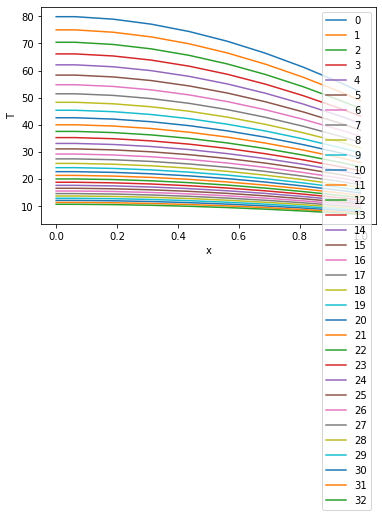

In [1993]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [1994]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    


Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.5002222514558525e-13; Avg. Resid. = 1.2714829189519605e-13
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 3.4727554705034436; Avg. Resid. = 3.061181838663444
Iteration = 1; Max. Resid. = 2.0161650127192843e-13; Avg. Resid. = 8.698597397938101e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 3.2608272954162203; Avg. Resid. = 2.8744759526193064
Iteration = 1; Max. Resid. = 1.5054624213917123e-13; Avg. Resid. = 6.947220576591917e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 3.061856991875402; Avg. Resid. = 2.6991474818645287
Iteration = 1; Max. Resid. = 1.438849039914203e-13; Avg. Resid. = 5.380418333089665e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 2.875051960307701; Avg. Resid. = 2.534509300990891
Iteration = 1; Max. Resid. = 1.7186252421197423e-13; Avg. Resid. = 7.981115768274094e-14
Timestep 

[10.67262853 10.67262853 10.64178358 10.58018281 10.48800425 10.36551433
 10.21306703 10.03110295  9.82014799  9.58081183  9.31378616  9.01984273
  8.69983106  8.354676    7.9853751   7.59299568  7.17867174  6.96113623]


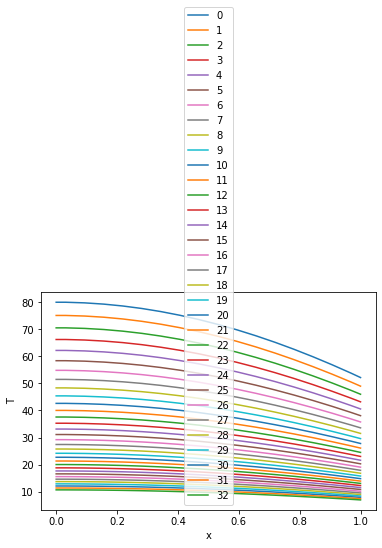

In [1995]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [1996]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    


Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 1.8500591664023887; Avg. Resid. = 1.630418626624646
Iteration = 1; Max. Resid. = 5.597744490160039e-13; Avg. Resid. = 2.2657570264428273e-13
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 1.7371929826472297; Avg. Resid. = 1.530925427652278
Iteration = 1; Max. Resid. = 6.128431095930864e-13; Avg. Resid. = 1.6191908924767517e-13
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 1.631214099132194; Avg. Resid. = 1.4375115780458998
Iteration = 1; Max. Resid. = 3.588240815588506e-13; Avg. Resid. = 1.462857612821722e-13
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 1.531696252387519; Avg. Resid. = 1.349799425848019
Iteration = 1; Max. Resid. = 3.6126657221302594e-13; Avg. Resid. = 1.279219785654817e-13
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 1.438245553032175; Avg. Resid. = 1.2674398532257527
Iteration = 1; Max. Resid. = 2.7555735471196385e-13; Avg. Resid. = 1.2031001195289548e-13
Timestep = 

[10.66917104 10.66917104 10.66145989 10.64604316 10.622932   10.5921431
 10.55369872 10.50762665 10.45396019 10.39273811 10.32400468 10.24780957
 10.16420784 10.07325993  9.97503156  9.86959373  9.75702264  9.63739965
  9.51081123  9.37734886  9.23710901  9.09019303  8.93670711  8.77676217
  8.61047382  8.43796225  8.25935213  8.07477256  7.88435694  7.6882429
  7.48657217  7.27949052  7.06714761  6.95842226]


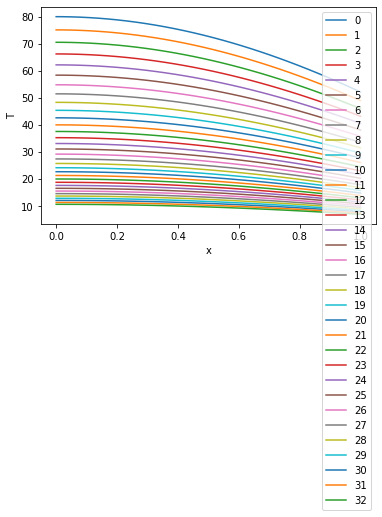

In [1997]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

# First Order Implicit Scheme

In [1998]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    


Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.6608936448392342e-13; Avg. Resid. = 7.152056724635259e-14
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 2.8988545320331833; Avg. Resid. = 2.5573262107559507
Iteration = 1; Max. Resid. = 9.170442183403793e-14; Avg. Resid. = 3.126388037344441e-14


In [1999]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error1 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


[19.22932462 19.22932462 19.08714452 18.80383572 18.38149323 17.82324016
 17.1332046  16.31648909 15.3791328  14.32806685 13.17106298 12.5438695 ]


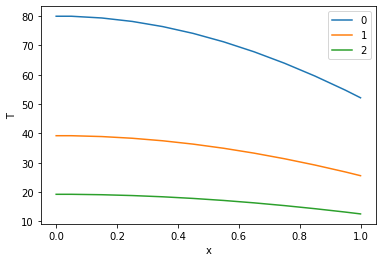

In [2000]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [2001]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    #Storing the temperature
    dt2 = dt 
    T2_2 = T[1]   
    timeStep_2 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.509903313490213e-13; Avg. Resid. = 7.278622149442527e-14
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 3.8898868479662942; Avg. Resid. = 3.431480242211589
Iteration = 1; Max. Resid. = 9.85878045867139e-14; Avg. Resid. = 5.553335569175033e-14
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 2.559986962812743; Avg. Resid. = 2.2585280016599447
Iteration = 1; Max. Resid. = 7.549516567451064e-14; Avg. Resid. = 3.5016434196677435e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 1.6848795729008257; Avg. Resid. = 1.4865001020622892
Iteration = 1; Max. Resid. = 3.430589146091734e-14; Avg. Resid. = 1.844080443902385e-14


In [2002]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error2 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


In [2003]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt3 = dt
    T2_3 = T[1]
    timeStep_3 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.5365486660812167e-13; Avg. Resid. = 9.241496456979803e-14
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 4.692018122552212; Avg. Resid. = 4.138843752758117
Iteration = 1; Max. Resid. = 5.684341886080802e-14; Avg. Resid. = 2.9132252166164105e-14
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 3.7243477596597776; Avg. Resid. = 3.285683361483618
Iteration = 1; Max. Resid. = 7.815970093361102e-14; Avg. Resid. = 3.7836400679225336e-14
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 2.9564785414947887; Avg. Resid. = 2.608355116708691
Iteration = 1; Max. Resid. = 5.861977570020827e-14; Avg. Resid. = 2.788880237858393e-14
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 2.346983980675325; Avg. Resid. = 2.070648988563958
Iteration = 1; Max. Resid. = 5.5289106626332

In [2004]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error3 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


In [2005]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.175606
time = 0.4535
value = [0.8047, 1.1559, 1.507, 1.85, 2.209, 2.56, 2.91, 3.2632]
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
Texact = []

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt4 = dt
    T2_4 = T[1]
    timeStep_4 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.629106
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.8740564655672642e-13; Avg. Resid. = 7.238654120556021e-14
Timestep = 1; Time = 0.8047120000000001
Iteration = 0; Max. Resid. = 5.231596708097043; Avg. Resid. = 4.614425437536791
Iteration = 1; Max. Resid. = 9.50350909079134e-14; Avg. Resid. = 3.4061642395499804e-14
Timestep = 2; Time = 0.9803180000000001
Iteration = 0; Max. Resid. = 4.629790507764539; Avg. Resid. = 4.0842285387921855
Iteration = 1; Max. Resid. = 7.815970093361102e-14; Avg. Resid. = 4.591882429849648e-14
Timestep = 3; Time = 1.1559240000000002
Iteration = 0; Max. Resid. = 4.097487996205159; Avg. Resid. = 3.61489820597917
Iteration = 1; Max. Resid. = 1.1191048088221578e-13; Avg. Resid. = 5.706546346573305e-14
Timestep = 4; Time = 1.33153
Iteration = 0; Max. Resid. = 3.6265166969856457; Avg. Resid. = 3.1994851303362113
Iteration = 1; Max. Resid. = 1.2656542480726785e-13; Avg. Resid. =

In [2006]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error4 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


In [2007]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt5 = dt
    T2_5 = T[1]
    timeStep_5 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.5587531265737198e-13; Avg. Resid. = 6.727951529228449e-14
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 5.550976956865838; Avg. Resid. = 4.89566880981793
Iteration = 1; Max. Resid. = 1.7674750552032492e-13; Avg. Resid. = 6.106226635438361e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 5.211992726673173; Avg. Resid. = 4.597341517975944
Iteration = 1; Max. Resid. = 8.348877145181177e-14; Avg. Resid. = 3.206324095117452e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 4.893862074355723; Avg. Resid. = 4.317134191234427
Iteration = 1; Max. Resid. = 1.0036416142611415e-13; Avg. Resid. = 3.1530333899354446e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 4.595296925153817; Avg. Resid. = 4.053982262420487
Iteration = 1; Max. Resid. = 1.0391687510491465e-13; Avg. Resid. = 5.226929999935237e-14
Timestep = 5; Tim

In [2008]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error5 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


The slope is [0.8832241061924297, 0.9359876696858631, 0.9592424459665247, 0.9605247217886043]


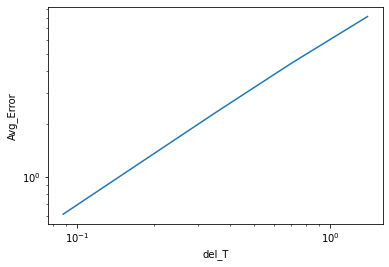

In [2009]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]

# Calculating the slope p for first order transient model
Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

plt.loglog(del_T, Avg_Error)
slope = [(Error_2-Error_1)/(dt_2-dt_1), (Error_3-Error_2)/(dt_3-dt_2), (Error_4-Error_3)/(dt_4-dt_3), (Error_5-Error_4)/(dt_5-dt_4) ]

print('The slope is', slope)

plt.xlabel("del_T")
plt.ylabel("Avg_Error")
plt.show()

## Temperature vs Time Step

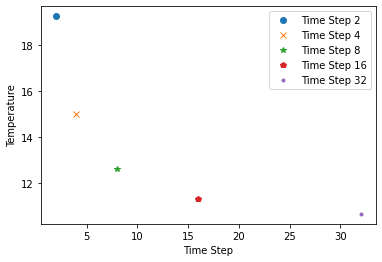

In [2010]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

plt.plot(timeStep_1, T2_1 , 'o', label='Time Step 2')
plt.plot(timeStep_2, T2_2 , 'x', label='Time Step 4')
plt.plot(timeStep_3, T2_3 , '*', label='Time Step 8')
plt.plot(timeStep_4, T2_4 ,'p',  label='Time Step 16')
plt.plot(timeStep_5, T2_5 , '.',  label='Time Step 32')

plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

## Second order implicit scheme

In [2011]:
class SecondOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, Told2, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Told2 = Told2
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        transient = ((self._rho*self._cp*self._grid.vol)*(1.5*self._T[1:-1] - 2*self._Told[1:-1] + 0.5*self._Told2[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (1.5*(self._rho*self._cp*self._grid.vol))/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [2012]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #print(T)
    T2_1 = T[1]
    timeStep_1 = nTime
    dt1 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.2131149139028805
Iteration = 1; Max. Resid. = 2.078337502098293e-13; Avg. Resid. = 1.1444178937836113e-13
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 4.655928236042242; Avg. Resid. = 4.107316325792593
Iteration = 1; Max. Resid. = 1.3877787807814457e-13; Avg. Resid. = 6.030731469763851e-14


[21.46121893 21.46121893 21.30254402 20.98636714 20.51502545 19.892003
 19.12190491 18.2104232  17.16429456 15.99125039 14.69995938 13.99996132]


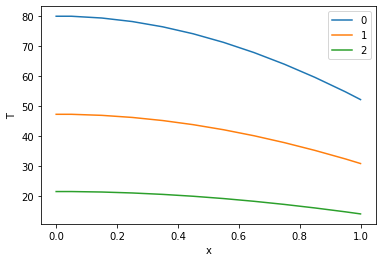

In [2013]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [2014]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error1 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
10.12273893380181


In [2015]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #Storing the temperature at x = 0 
    T2_2 = T[1]
    timeStep_2 = nTime
    dt2 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.2131149139028805
Iteration = 1; Max. Resid. = 7.682743330406083e-14; Avg. Resid. = 2.6867397195928788e-14
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 5.853636575069166; Avg. Resid. = 5.1636515980150595
Iteration = 1; Max. Resid. = 1.1901590823981678e-13; Avg. Resid. = 3.708144902248023e-14
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 4.333509960651707; Avg. Resid. = 3.823303528805809
Iteration = 1; Max. Resid. = 7.949196856316121e-14; Avg. Resid. = 3.3484326422694724e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 2.842728252050907; Avg. Resid. = 2.5080857046710676
Iteration = 1; Max. Resid. = 4.629630012686903e-14; Avg. Resid. = 1.579847364041598e-14


In [2016]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error2 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
3.5818471675142503


In [2017]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    T2_3 = T[1]
    timeStep_3 = nTime
    dt3 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.4033219031261979e-13; Avg. Resid. = 6.927791673660977e-14
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 6.717900814354189; Avg. Resid. = 5.925609271550252
Iteration = 1; Max. Resid. = 1.2168044349891716e-13; Avg. Resid. = 4.929390229335695e-14
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 5.954936428393802; Avg. Resid. = 5.253598382565874
Iteration = 1; Max. Resid. = 9.237055564881302e-14; Avg. Resid. = 4.8760995241536874e-14
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 4.859407007845121; Avg. Resid. = 4.287339240375494
Iteration = 1; Max. Resid. = 1.141309269314661e-13; Avg. Resid. = 2.9554136915521666e-14
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 3.8310978814111705; Avg. Resid. = 3.380080270504197
Iteration = 1; Max. Resid. = 7.2608585810485

In [2018]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error3 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
1.312604510664592


[11.47545588 11.47545588 11.3906081  11.22153988 10.9695013  10.6363559
 10.22456691  9.73717905  9.17779599  8.55055373  7.86009001  7.48580001]


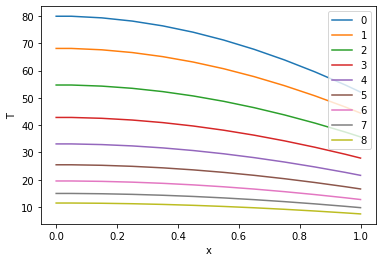

In [2019]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [2020]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.17560625
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    T2_4 = T[1]
    timeStep_4 = nTime
    dt4 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.3278267374516872e-13; Avg. Resid. = 7.456257833382552e-14
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 7.253648934759171; Avg. Resid. = 6.397582948066001
Iteration = 1; Max. Resid. = 2.0516921495072893e-13; Avg. Resid. = 5.861977570020827e-14
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 7.0865318407010225; Avg. Resid. = 6.251356603954619
Iteration = 1; Max. Resid. = 7.37188088351104e-14; Avg. Resid. = 3.299582829185965e-14
Timestep = 3; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 6.470439586119783; Avg. Resid. = 5.708484435068255
Iteration = 1; Max. Resid. = 9.325873406851315e-14; Avg. Resid. = 3.805844528415037e-14
Timestep = 4; Time = 1.3315312499999998
Iteration = 0; Max. Resid. = 5.7659929288585765; Avg. Resid. = 5.087170907819571
Iteration = 1; Max. Resid. = 9.370282327836321e-14; Av

In [2021]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error4 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
0.6118969657101482


[10.68123907 10.68123907 10.60226362 10.44489666 10.21030174  9.90021341
  9.51692441  9.06326873  8.54260064  7.95876986  7.31609315  6.96770776]


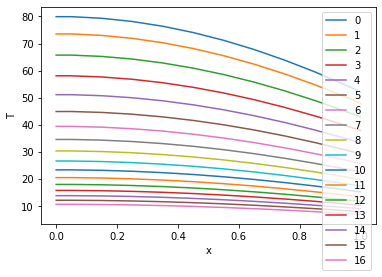

In [2022]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [2023]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    T2_5 = T[1]
    timeStep_5 = nTime
    dt5 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.541303125
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 2.0605739337042905e-13; Avg. Resid. = 7.007727731433989e-14
Timestep = 1; Time = 0.62910625
Iteration = 0; Max. Resid. = 7.5551041860260915; Avg. Resid. = 6.6628760280799995
Iteration = 1; Max. Resid. = 1.723066134218243e-13; Avg. Resid. = 6.754596881819452e-14
Timestep = 2; Time = 0.716909375
Iteration = 0; Max. Resid. = 7.765938686558801; Avg. Resid. = 6.849787792507745
Iteration = 1; Max. Resid. = 1.127986593019159e-13; Avg. Resid. = 5.46229728115577e-14
Timestep = 3; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 7.510562605838297; Avg. Resid. = 6.625381537836816
Iteration = 1; Max. Resid. = 6.750155989720952e-14; Avg. Resid. = 3.312905505481467e-14
Timestep = 4; Time = 0.8925156249999999
Iteration = 0; Max. Resid. = 7.117125914167497; Avg. Resid. = 6.27884176868169
Iteration = 1; Max. Resid. = 1.234568003383174e-13; Avg. Resid. = 6.15

In [2024]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
    Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error5 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
0.3100190480740309


[10.33907571 10.33907571 10.26263017 10.11030431  9.88322441  9.58306946
  9.21205876  8.77293552  8.26894653  7.70381821  7.08172905  6.74450386]


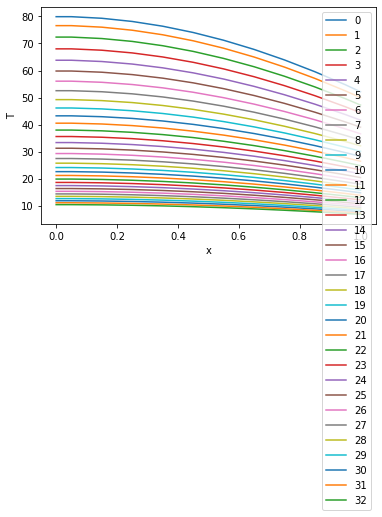

In [2025]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Error vs dt plot

The slope is [1.4988240103764636, 1.4482714848936542, 1.1010716457018577, 0.9809318853682933]


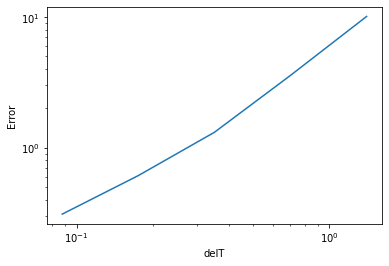

In [2026]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
#from scipy import stats

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]
slope, intercept, r_value, p_value, std_err = stats.linregress(del_T, Avg_Error)
# Calculating the slope p for second order transient model

Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

plt.loglog(del_T, Avg_Error)
slope_Manual = [(Error_1-Error_2)/(dt_1-dt_2), (Error_2-Error_3)/(dt_2-dt_3), (Error_3-Error_4)/(dt_3-dt_4), (Error_4-Error_5)/(dt_4-dt_5) ]
print('The slope is', slope_Manual)


plt.xlabel("delT")
plt.ylabel("Error")
plt.show()

## Temperature vs Time Step plot

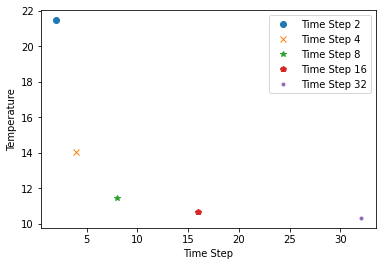

In [2027]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

plt.plot(timeStep_1, T2_1 , 'o', label='Time Step 2')
plt.plot(timeStep_2, T2_2 , 'x', label='Time Step 4')
plt.plot(timeStep_3, T2_3 , '*', label='Time Step 8')
plt.plot(timeStep_4, T2_4 ,'p',  label='Time Step 16')
plt.plot(timeStep_5, T2_5 , '.',  label='Time Step 32')

plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

## Crank Nicolson Scheme

In [2158]:
class DiffusionModel_CrankNicolson1:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc, w, phi_old):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._w = w
        self._phi_old = phi_old
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = -self._w*self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = -self._w*self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        flux_w_CN = -( 1 - self._w)*self._gamma*self._grid.Aw*(self._phi_old[1:-1]-self._phi_old[0:-2])/self._grid.dx_WP
        flux_e_CN = -(1- self._w)*self._gamma*self._grid.Ae*(self._phi_old[2:]-self._phi_old[1:-1])/self._grid.dx_PE
       
        # Calculate the linearization coefficients
        coeffW = - self._w*self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._w*self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = ( - coeffW - coeffE)
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = (flux_e - flux_w) + (flux_e_CN - flux_w_CN)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [2175]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
       # coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.0436096431476471e-13; Avg. Resid. = 5.74651437545981e-14
[25.28097817 25.28097817 25.09419642 24.72201749 24.16720029 23.43385778
 22.52742669 21.45462743 20.22341468 18.84291876 17.32337849 16.49845571]
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 1.8678174761308948; Avg. Resid. = 1.6498455705203043
Iteration = 1; Max. Resid. = 4.8627768478581856e-14; Avg. Resid. = 2.0528023725319145e-14
[8.00009986 8.00009986 7.94086419 7.82282409 7.64683866 7.41418813
 7.12656385 6.78605495 6.39513195 5.95662722 5.47371249 5.21305952]


[8.00009986 8.00009986 7.94086419 7.82282409 7.64683866 7.41418813
 7.12656385 6.78605495 6.39513195 5.95662722 5.47371249 5.21305952]


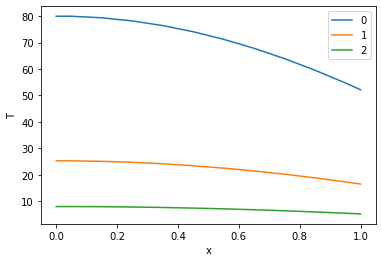

In [2176]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [2177]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)
dt1 = dt
Error1 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
1.755469624167425


In [2178]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    dt2 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 6.261657858885883e-14; Avg. Resid. = 2.375877272697835e-14
[46.97014526 46.97014526 46.62293725 45.93109542 44.89974924 43.53654588
 41.85159423 39.85739078 37.56872823 35.00258721 32.17801221 30.64572592]
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 3.4720800253025876; Avg. Resid. = 3.064572591613346
Iteration = 1; Max. Resid. = 3.8191672047105385e-14; Avg. Resid. = 1.5298873279334658e-14
[27.60655405 27.60655405 27.40242658 26.99567135 26.38927612 25.58769322
 24.5968047  23.42387596 22.0774983  20.56752056 18.90497016 18.00473349]
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 2.0412747682320993; Avg. Resid. = 1.800473348804898
Iteration = 1; Max. Resid. = 1.3322676295501878e-14; Avg. Resid. = 6.195044477408373e-15
[16.22346718 16.22346718 16.10348641 15.86442102 15.50805789 15.03706377
 14.4

In [2179]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(E_bar)
#dt2 = dt
Error2 = E_bar

0.3995956041692562


[9.5349919  9.5349919  9.46453312 9.32412942 9.11480311 8.83807399
 8.49594257 8.09086716 7.62573416 7.10382082 6.52874932 6.2178565 ]


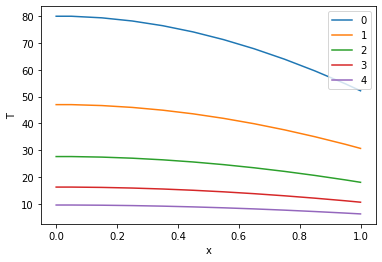

In [2180]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [2181]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    dt3 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 5.10702591327572e-14; Avg. Resid. = 2.2115642650533117e-14
[61.55403498 61.55403498 61.09891143 60.1920402  58.84014859 57.05326671
 54.84465501 52.23070868 49.23083977 45.86733803 42.16521174 40.15734452]
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 4.551235482879931; Avg. Resid. = 4.015734451550255
Iteration = 1; Max. Resid. = 7.904787935331115e-14; Avg. Resid. = 3.7347902548390263e-14
[47.40725823 47.40725823 47.05678535 46.35842312 45.31731789 43.94113749
 42.24000909 40.22643643 37.91519607 35.32321265 32.46941243 30.92324993]
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 3.504728783034209; Avg. Resid. = 3.0923249929013226
Iteration = 1; Max. Resid. = 4.574118861455645e-14; Avg. Resid. = 1.98507876802978e-14
[36.51129845 36.51129845 36.24129456 35.70328562 34.90125666 33.84115423
 32.53085

In [2182]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)
dt3 = dt
Error3 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
0.08342007974514179


[9.89311266 9.89311266 9.81995883 9.67419747 9.45691719 9.16973963
 8.81480233 8.39472777 7.91256797 7.37170492 6.77567207 6.45302102]


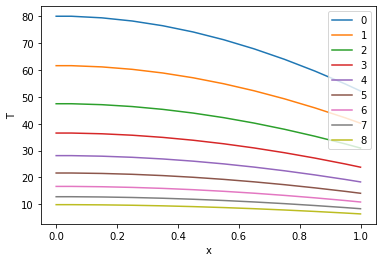

In [2183]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [2184]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.17561
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    dt4 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.6291100000000001
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 8.970602038971265e-14; Avg. Resid. = 2.8244073746463983e-14
[70.18001682 70.18001682 69.66102091 68.62687899 67.08526365 65.04761606
 62.52906578 59.54832541 56.12756174 52.29224539 48.07098164 45.78188728]
Timestep = 1; Time = 0.8047200000000001
Iteration = 0; Max. Resid. = 5.189959085383008; Avg. Resid. = 4.578188727799026
Iteration = 1; Max. Resid. = 6.483702463810914e-14; Avg. Resid. = 2.4513724383723458e-14
[61.62261996 61.62261996 61.1670248  60.25920522 58.90587532 57.1170375
 54.90589885 52.28875748 49.28485645 45.91620106 42.20733348 40.19746046]
Timestep = 2; Time = 0.9803300000000001
Iteration = 0; Max. Resid. = 4.5559515826480625; Avg. Resid. = 4.019746045970091
Iteration = 1; Max. Resid. = 6.483702463810914e-14; Avg. Resid. = 2.424727085781342e-14
[54.10936396 54.10936396 53.70928393 52.91207568 51.72362249 50.15269956
 48.2109

In [2185]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)
dt4 = dt
print(dt4)
Error4 = E_bar
print(E_bar)

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]
0.17561
0.006060466650622853


[9.98081536 9.98081536 9.9070199  9.75997404 9.5407633  9.25100532
 8.89284071 8.46892671 7.98242981 7.43696636 6.83625546 6.51071949]


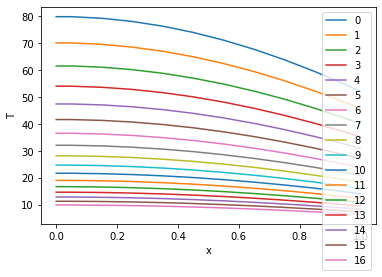

In [2186]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [2187]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.541303125
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 6.039613253960852e-14; Avg. Resid. = 3.197442310920451e-14
[74.90059079 74.90059079 74.34661925 73.24278233 71.59726392 69.42226954
 66.73394383 63.55226416 59.900914   55.80714193 51.30161493 48.85868088]
Timestep = 1; Time = 0.62910625
Iteration = 0; Max. Resid. = 5.539715381403453; Avg. Resid. = 4.885868088186068
Iteration = 1; Max. Resid. = 6.217248937900877e-14; Avg. Resid. = 3.801403636316536e-14
[70.18991715 70.18991715 69.67088049 68.63665857 67.09492455 65.05711317
 62.53832766 59.5572089  56.13575764 52.29909223 48.07511002 45.78581907]
Timestep = 2; Time = 0.716909375
Iteration = 0; Max. Resid. = 5.190366582048113; Avg. Resid. = 4.57858190693744
Iteration = 1; Max. Resid. = 7.37188088351104e-14; Avg. Resid. = 3.321787289678468e-14
[65.77614046 65.77614046 65.2897968  64.32070497 62.87602729 60.96643674
 58.60603653 55.81226315 52.605789

In [2188]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(E_bar)
dt5 = dt
Error5 = E_bar

0.013690533167236474


[10.00320231 10.00320231  9.92924018  9.78186276  9.5621597   9.27175547
  8.91279755  8.48793992  8.00032141  7.4535555   6.85167216  6.52540206]


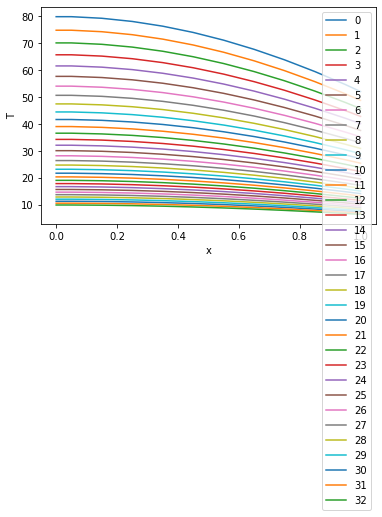

In [2189]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

The slope is [2.135244415031303, 2.260074116084666, 3.7830104483924645, 1.175641624016497]


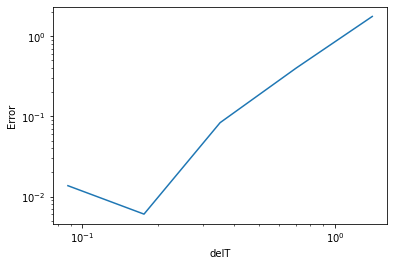

In [2190]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy import stats

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]

slope, intercept, r_value, p_value, std_err = stats.linregress(del_T, Avg_Error)

# Calculating the slope p for second order transient model
Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

plt.loglog(del_T, Avg_Error)
slope = [(Error_2-Error_1)/(dt_2-dt_1), (Error_3-Error_2)/(dt_3-dt_2), (Error_4-Error_3)/(dt_4-dt_3),(Error_5-Error_4)/(dt_4-dt_5) ]

print('The slope is', slope)

plt.xlabel("delT")
plt.ylabel("Error")
plt.show()

## Try 2